In [1]:
%pylab inline
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import time, sys
from IPython.display import clear_output
from scipy import stats
import scipy.stats
import scipy.optimize as opt
import scipy.io
# %load_ext jupyternotify
#Progress bar function
import time, sys

def update_progress(progress):
    barLength = 100 # Modify this to change the length of the progress bar
    status = ""
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Halt...\r\n"
    if progress >= 1:
        progress = 1
        status = "Done...\r\n"
    block = int(round(barLength*progress))
    text = "\rPercent: [{0}] {1}% {2}".format( "#"*block + "-"*(barLength-block), progress*100, status)
    sys.stdout.write(text)
    sys.stdout.flush()

Populating the interactive namespace from numpy and matplotlib


In [2]:
#define F-test function
def f_test(x, y):
    x = np.array(x)
    y = np.array(y)
    f = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic 
    dfn = x.size-1 #define degrees of freedom numerator 
    dfd = y.size-1 #define degrees of freedom denominator 
    p = 1-scipy.stats.f.cdf(f, dfn, dfd) #find p-value of F test statistic 
    return f,p
# We have functions to convert proportion correct to z scores and vice versa
def ztop(z):
    p=0.5 * (1.0+scipy.special.erf(z/np.sqrt(2) ) )
    return p

def ptoz(p):
    if p==1:
        p=0.9999999
    elif p==0:
        p=0.0000001
    z=np.sqrt(2) * scipy.special.erfinv( 2*p-1.0)
    return z

def ptozM(p,M=10):
    if p==1:
        p=0.999999
    elif p==0:
        p=0.0001
    # from JEK Smith 1982. Checked to match tables of Hacker/Ratcliff
    K_M=0.86-0.085 * np.log(M-1)
    d=K_M*np.log( (M-1)*p/(1-p) )
    return d

# Function for getting bootstrapped zscores
def bootstrap_corr_to_z(df):
    num_boot=1000
    z_scores=[]
    for i in range(num_boot):
        resampled_df=df.sample(len(df),replace=True)
        zVal=ptozM(resampled_df.mean())
        z_scores.append(zVal)
    return z_scores

# Function for getting bootstrapped prop values from 0/1 correct/incorrect response list
def bootstrap_corr_to_propCor(df,num_boot=1000):
    propCor=[]
    for i in range(num_boot):
        resampled_df=df.sample(len(df),replace=True)
        propCor.append(resampled_df.mean())
    return propCor

## Perumutation Test
def perm_test(c,t,num_perm,method='mean',z_score=True,*args):
    k=[]
    # Look if there are additional groups passed in
    if len(args)>1:
        t1=args[0]
        t2=agrs[1]
                
    if method=='mean':
        if z_score==True:
            diff=(ptozM(np.mean(c))-ptozM(np.mean(t)))
        else:
            diff=((np.mean(c))-(np.mean(t)))
        z=np.concatenate([c,t])
        for i in range(num_perm):
            np.random.shuffle(z)
            # Since the number of samples in each group is unequal we would match the
            # distribution to the individual lengths of each data series
            if z_score==True:
                k.append((ptozM(np.mean(z[:int(len(c))])) - ptozM(np.mean(z[int(len(c)):]))))  
            else:
                k.append(((np.mean(z[:int(len(c))])) - (np.mean(z[int(len(c)):]))))  
    elif method=='ttest':
        # Compare between two sets of measures/data
        diff=stats.ttest_ind(c,t).statistic
        z=np.concatenate([c,t])
        for i in range(num_perm):
            np.random.shuffle(z)
            # Since the number of samples in each group is unequal we would match the
            # distribution to the individual lengths of each data series
            tval=stats.ttest_ind(z[:int(len(c))],z[int(len(c)):])
            k.append(tval.statistic)
        
    elif method=='ftest':
        for arg in args:
            t2=arg
        if 't2' in locals():
            # Compare between more than two sets of measures/data
            diff,p_val=stats.f_oneway(c,t,t2).statistic
            z=np.concatenate([c,t,t2])
            for i in range(num_perm):
                np.random.shuffle(z)
                # Since the number of samples in each group is unequal we would match the
                # distribution to the individual lengths of each data series
                g1=z[:int(len(c))]
                g2=z[int(len(c)):(int(len(c))+int(len(t)))]
                g3=z[(int(len(c))+int(len(t))):]
                fval=stats.f_oneway(g1,g2,g3).statistic
                k.append(fval)
        else:
            # Compare between  two sets of measures/data
            diff,p_val=f_test(c,t)
            z=np.concatenate([c,t])
            for i in range(num_perm):
                np.random.shuffle(z)
                # Since the number of samples in each group is unequal we would match the
                # distribution to the individual lengths of each data series
                g1=z[0:int(len(c))]
                g2=z[int(len(c))::]
                fval,p_val=f_test(g1,g2)
                k.append(fval)
        
    elif method=='friedman':
        # compare between two sets of measures/data
        diff=stats.friedmanchisquare(c,t,t1,t2).statistic
        z=np.concatenate([c,t,t1,t2])
        for i in range(num_perm):
            np.random.shuffle(z)
            # Since the number of samples in each group is unequal we would match the
            # distribution to the individual lengths of each data series
            len_df=len(c) # since lengths of groups are the same we use one of them
            g1=z[0:len_df]
            g2=z[len_df*1:len_df*2]
            g3=z[len_df*2:len_df*3]
            g4=z[len_df*3:len_df*4]
            friedman_test=stats.friedmanchisquare(g1,g2,g3,g4)
            k.append(friedman_test.statistic)
    if method=='mean':
        k=np.array(k)
        if diff>0: # when the original difference is positive
            p_value=len(np.where(k>=diff)[0])/num_perm
        elif diff<0: # when the original difference is negative
            p_value=len(np.where(k<=diff)[0])/num_perm
        elif diff==0 and np.mean(k)>0: # when the original difference is zero and distribution is positive
            p_value=len(np.where(k<=diff)[0])/num_perm
        elif diff==0 and np.mean(k)<0:# when the original difference is zero and distribution is negative
            p_value=len(np.where(k>=diff)[0])/num_perm
        else:# It wouldnt normally get here but just to prevent bugs
            p_value=1
    else: # all other test statistic
        if diff<np.mean(k):
            p_value=len(np.where(k<=diff)[0])/num_perm
        elif diff>np.mean(k):
            p_value=len(np.where(k>=diff)[0])/num_perm
    
    # check if p_value exists, if not assign it a high value
    if 'p_value' not in locals():
        print('UnboundLocalError')
        p_value=1
    
            
    return {"diff":diff,"k":k,'p_val':p_value}

In [104]:
if sys.platform=='win32':
#     data_directory='Z:\TSLO_Experiment\VoluntaryMicrosaccade\Experiment2ObliqueMicrosaccadeWNeutral'
    data_directory='Z:\TSLO_Experiment\CrowdingMOCS\ControlExperiment'
elif sys.platform=='linux':
    data_directory='/home/coateslab/LabData/TSLO_Experiment/VoluntaryMicrosaccade/Experiment1AllFlankers/'
filedir_list=[]
for root,dirs,file in os.walk(data_directory):
    if "Videos" in  root and "Processed" not in root and "Pilot" not in root and "Training" not in root:
        filedir_list.append(root)

behav_compile=True
if behav_compile==True:
    # we get the path for the inidividual behavioral data files
    if sys.platform=='win32':
        behavdata_dir='Z:\TSLO_Experiment\CrowdingMOCS\ControlExperiment'
    elif sys.platform=='linux':
        behavdata_dir='/home/coateslab/LabData/TSLO_Experiment/VoluntaryMicrosaccade/Experiment1AllFlankers/'
    behavdir_list=[]
    for root,dirs,file in os.walk(behavdata_dir):
        if "Behav"in root and "Pilot" not in root and "Training" not in root:
            behavdir_list.append(root)
        
# Saccade data compilation
# % time
# This cell compiles the saccade metrics obtained from the ReVAS eye position filters and saccade(and drift) detection functions
# In this case we obtain the saccade and drift metrics from the mat files that are created by ReVAS
failedMicroSacc=[]
microSaccData=[]
driftData=[]
create_pickle= False
# while create_dataframe==True:
num_elements=len(filedir_list)
counter=0
for foldername in filedir_list:
    update_progress(counter/num_elements)
    counter+=1
    failedMicroSacc=os.listdir(foldername)
    filelist=os.listdir(foldername)
    subj_id=foldername[foldername.find("S0"):(foldername.find("S0")+3)]
    for filename in filelist:
        if 'sacsdrifts' in filename:
            try:
                # First we load the mat file into jupyter
                mat=scipy.io.loadmat(os.path.join(foldername,filename))
                # we get the foldername from the filepath
    #             folderdate=foldername.replace('/mnt/hd/ao/vids/','')
                # initially we create empty pandas dataframes
                tempSaccData=pd.DataFrame({'Duration':[],'onsetIdx':[],'offsetIdx':[],'onsetTime':[],'offsetTime':[],'xAmp':[],'yAmp':[]\
                                           ,'VectorAmp':[],'Direction':[],'peakVel':[],'meanVel':[]})
                # 1. form saccade dataset for the file
                if mat['params']['saccades'][0,0]==0 or len((mat['params']['saccades'][0,0]))==0 or (mat['params']['saccades'][0,0].size)==0:
                    tempSaccData=tempSaccData.append({'Duration':np.nan,'onsetIdx':np.nan,'offsetIdx':np.nan,'onsetTime':np.nan,\
                                                      'offsetTime':np.nan,'xAmp':np.nan,'yAmp':np.nan,\
                                                      'VectorAmp':np.nan,'Direction':np.nan,'peakVel':np.nan,'meanVel':np.nan},ignore_index=True)
                else:
                    # we determine the size of the saccade array
                    tempSaccData=pd.DataFrame({'Duration':[],'onsetIdx':[],'offsetIdx':[],'onsetTime':[],'offsetTime':[],'xAmp':[],'yAmp':[]\
                                           ,'VectorAmp':[],'Direction':[],'peakVel':[],'meanVel':[]})

                    saccArraySize=mat['params']['saccades'][0,0]['duration'].size # for now use one of the fields of the struct array
                    durationList=[]
                    onsetIdxList=[]
                    offsetIdxList=[]
                    onsetTimeList=[]
                    offsetTimeList=[]
                    xAmpList=[]
                    yAmpList=[]
                    VectorAmpList=[]
                    DirectionList=[]
                    peakVelList=[]
                    maxVelList=[]
                    for itemIdx in range(saccArraySize): #here we would want to unapack each item from the struct and append it to a list 
                        duration=(mat['params']['saccades'][0,0]['duration'][itemIdx].flatten().item().item())
                        onsetIdx=(mat['params']['saccades'][0,0]['onsetIndex'][itemIdx].flatten().item().item())
                        offsetIdx=(mat['params']['saccades'][0,0]['offsetIndex'][itemIdx].flatten().item().item())
                        onsetTime=((mat['params']['saccades'][0,0]['onsetTime'][itemIdx].flatten().item().item()))
                        offsetTime=(mat['params']['saccades'][0,0]['offsetTime'][itemIdx].flatten().item().item())
                        xAmp=(mat['params']['saccades'][0,0]['xAmplitude'][itemIdx].flatten().item().item())
                        yAmp=(mat['params']['saccades'][0,0]['yAmplitude'][itemIdx].flatten().item().item())
                        VectorAmp=(mat['params']['saccades'][0,0]['vectorAmplitude'][itemIdx].flatten().item().item())
                        Direction=(mat['params']['saccades'][0,0]['direction'][itemIdx].flatten().item().item())
                        peakVel=(mat['params']['saccades'][0,0]['peakVelocity'][itemIdx].flatten().item().item())
                        maxVel=(mat['params']['saccades'][0,0]['meanVelocity'][itemIdx].flatten().item().item())

                        tempSaccData=tempSaccData.append({'Duration':duration,'onsetIdx':onsetIdx,'offsetIdx':offsetIdx,'onsetTime':onsetTime,\
                                  'offsetTime':offsetTime,'xAmp':xAmp,'yAmp':yAmp,'VectorAmp':VectorAmp,'Direction':Direction\
                                  ,'peakVel':peakVel,'meanVel':maxVel},ignore_index=True)
                # We finally add file details to the data structure which can later be used to 
                # query into the dataframe
                tempSaccData['filename']=filename
                trialCode='%s'%(filename[0:filename.find('_Video')])
                tempSaccData['code']=trialCode
                tempSaccData['subj_id']=subj_id
                if 'NoMicrosaccade' in filename:
                    tempSaccData['microsaccade_cond']='NoMicrosaccade'
                else:
                    tempSaccData['microsaccade_cond']='Microsaccade'
    #             tempSaccData['foldername']=folderdate
    #             tempSaccData['code']='%s_%s'%(folderdate,filename[0:filename.find('_Eye')])
                #The temporary data is then appended to the bigger data structure 
                microSaccData.append(tempSaccData)
            except:
                failedMicroSacc.append(os.path.join(foldername,filename))
# create_dataframe=True
microSaccData=pd.concat(microSaccData)
# we then remove the saccade data with NaNs
microSaccFiltered=microSaccData[microSaccData['Direction'].notnull()]

# Drift data compilation
# % time
# This cell compiles the saccade metrics obtained from the ReVAS eye position filters and saccade(and drift) detection functions
# In this case we obtain the saccade and drift metrics from the mat files that are created by ReVAS
failedDrifts=[]
driftData=[]
create_pickle= False
# while create_dataframe==True:
num_elements=len(filedir_list)
counter=0
for foldername in filedir_list:
    update_progress(counter/num_elements)
    counter+=1
    failedMicroSacc=os.listdir(foldername)
    filelist=os.listdir(foldername)
    subj_id=foldername[foldername.find("S0"):(foldername.find("S0")+3)]
    for filename in filelist:
        if 'sacsdrifts' in filename:
            try:
                # First we load the mat file into jupyter
                mat=scipy.io.loadmat(os.path.join(foldername,filename))
                # we get the foldername from the filepath
    #             folderdate=foldername.replace('/mnt/hd/ao/rotVids/','')
                # initially we create empty pandas dataframes
                tempDriftData=pd.DataFrame({'Duration':[],'onsetIdx':[],'offsetIdx':[],'onsetTime':[],'offsetTime':[],'xAmp':[],'yAmp':[]\
                                           ,'VectorAmp':[],'Direction':[],'peakVel':[],'meanVel':[]})
                # 1. form saccade dataset for the file
                if mat['params']['drifts'][0,0]==0 or len((mat['params']['drifts'][0,0]))==0 or (mat['params']['drifts'][0,0].size)==0:
                    tempDriftData=tempSaccData.append({'Duration':np.nan,'onsetIdx':np.nan,'offsetIdx':np.nan,'onsetTime':np.nan,\
                                                      'offsetTime':np.nan,'xAmp':np.nan,'yAmp':np.nan,\
                                                      'VectorAmp':np.nan,'Direction':np.nan,'peakVel':np.nan,'meanVel':np.nan},ignore_index=True)
                else:
                    # we determine the size of the saccade array
                    tempSaccData=pd.DataFrame({'Duration':[],'onsetIdx':[],'offsetIdx':[],'onsetTime':[],'offsetTime':[],'xAmp':[],'yAmp':[]\
                                           ,'VectorAmp':[],'Direction':[],'peakVel':[],'meanVel':[]})

                    driftArraySize=mat['params']['drifts'][0,0]['duration'].size # for now use one of the fields of the struct array
                    durationList=[]
                    onsetIdxList=[]
                    offsetIdxList=[]
                    onsetTimeList=[]
                    offsetTimeList=[]
                    xAmpList=[]
                    yAmpList=[]
                    VectorAmpList=[]
                    DirectionList=[]
                    peakVelList=[]
                    maxVelList=[]
                    for itemIdx in range(driftArraySize): #here we would want to unapack each item from the struct and append it to a list 
                        duration=(mat['params']['drifts'][0,0]['duration'][itemIdx].flatten().item().item())
                        onsetIdx=(mat['params']['drifts'][0,0]['onsetIndex'][itemIdx].flatten().item().item())
                        offsetIdx=(mat['params']['drifts'][0,0]['offsetIndex'][itemIdx].flatten().item().item())
                        onsetTime=((mat['params']['drifts'][0,0]['onsetTime'][itemIdx].flatten().item().item()))
                        offsetTime=(mat['params']['drifts'][0,0]['offsetTime'][itemIdx].flatten().item().item())
                        xAmp=(mat['params']['drifts'][0,0]['xAmplitude'][itemIdx].flatten().item().item())
                        yAmp=(mat['params']['drifts'][0,0]['yAmplitude'][itemIdx].flatten().item().item())
                        VectorAmp=(mat['params']['drifts'][0,0]['vectorAmplitude'][itemIdx].flatten().item().item())
                        Direction=(mat['params']['drifts'][0,0]['direction'][itemIdx].flatten().item().item())
                        peakVel=(mat['params']['drifts'][0,0]['peakVelocity'][itemIdx].flatten().item().item())
                        maxVel=(mat['params']['drifts'][0,0]['meanVelocity'][itemIdx].flatten().item().item())

                        tempDriftData=tempDriftData.append({'Duration':duration,'onsetIdx':onsetIdx,'offsetIdx':offsetIdx,'onsetTime':onsetTime,\
                                  'offsetTime':offsetTime,'xAmp':xAmp,'yAmp':yAmp,'VectorAmp':VectorAmp,'Direction':Direction\
                                  ,'peakVel':peakVel,'meanVel':maxVel},ignore_index=True)
                # We finally add file details to the data structure which can later be used to 
                # query into the dataframe
                tempDriftData['filename']=filename
                trialCode='%s'%(filename[0:filename.find('_Video')])
                if "_2.5_" in trialCode:
                    trialCode=trialCode.replace("_2.5_","_2.50_")
                tempSaccData['code']=trialCode
                tempDriftData['subj_id']=subj_id
                if 'NoMicrosaccade' in filename:
                    tempDriftData['microsaccade_cond']='NoMicrosaccade'
                else:
                    tempDriftData['microsaccade_cond']='Microsaccade'
    #             tempDriftData['foldername']=folderdate
    #             tempDriftData['code']='%s_%s'%(folderdate,filename[0:filename.find('_Eye')])

                #The temporary data is then appended to the bigger data structure 
                driftData.append(tempDriftData)
            except:
                failedMicroSacc.append(os.path.join(foldername,filename))
#     create_dataframe=False
driftData=pd.concat(driftData)
# we then remove the saccade data with NaNs
driftDataFiltered=driftData[driftData['Direction'].notnull()]
  

if behav_compile==True:
    # Behav Data compilation
    behavdir_listles=[]
    behavData=[]
    questData=[]

    num_elements=len(behavdir_list)
    for foldername in behavdir_list:
        # we find subject ID
        subj_id=foldername[foldername.find('S0'):foldername.find('S0')+3]
        filelist=os.listdir(foldername)
        for filename in filelist:
            try:
                if 'Crowding' in filename and 'CrowdingQuest' not in filename and 'CrowdingThresh' not in filename:
                    # First we load the mat file into jupyter
                    tempBehav=pd.read_csv(os.path.join(foldername,filename))
                    tempBehav['filename']=filename
                    trialCode='%s'%(filename[0:filename.find('_Crowding')])
                    tempBehav['code']=trialCode
                    tempBehav['subj_id']=subj_id
                    #The temporary data is then appended to the bigger data structure 
                    behavData.append(tempBehav)
                elif "CrowdingThresh" in filename:
                    #We again load data into jupyter
                    tempData=pd.read_csv(os.path.join(foldername,filename))
                    tempData['subj_id']=subj_id
                    # ///rly we build the dataframe
                    questData.append(tempData)
            except:
                print(filename)
    if len(questData)!=0:
        questData=pd.concat(questData)
    behavData=pd.concat(behavData)
    
    
# Marker data compilation
failedFiles=[]
markerData=[]
markerFixNeeded=True
# while create_dataframe==True:
counter=0
num_elements=len(filedir_list)
for foldername in filedir_list:
#     update_progress(counter/num_elements)
    counter+=1
    filelist=os.listdir(foldername)
    subj_id=foldername[foldername.find("S0"):(foldername.find("S0")+3)]
    for filename in filelist:
        if 'marker' in filename and 'markerData' not in filename:
            # First we load the mat file into jupyter
            tempData=pd.read_csv(os.path.join(foldername,filename),names=['frameIdx','stripIdx'])
            tempData['stimulusOnsetTime']=(tempData['frameIdx']*(1000/30)/1000)+(tempData['stripIdx']*(1000/16000)/1000)
            if markerFixNeeded==True:
                if len(tempData)!=2: # Cases where marker is missing we get values from behav data
                    if "NoMicrosaccade" in filename:
                        trialCode='%s'%(filename[0:filename.find('_Video')])
                    else:
                        trialCode='%s'%(filename[0:filename.find('_Microsaccade')])
                    # Get this from the marker file, since the first marker would correspond to the cue onset. 
                    # The second missing one would correspond to the target onset
                    if len(tempData)>0:
                        cueOnsetTime=tempData['stimulusOnsetTime'].iloc[0]
                        # We get the behavioral data from the trial
                        behavDataTrial=behavData.query("code==@trialCode")
                        if len(behavDataTrial)>0: # valid ones
                            # We get this from behavioral data
                            cueDuration=behavDataTrial['cueDuration'].iloc[0]
                            # Using the two we figure out when the target happened
                            targetOnsetTime=cueOnsetTime+cueDuration
                            # We create a df with dummy strip values & calculation target onset time
                            markerFix=pd.DataFrame([[np.nan,np.nan,targetOnsetTime]],columns=['frameIdx','stripIdx','stimulusOnsetTime'])
                            # We finally append this to existing marker data
                            tempData=tempData.append(markerFix)


            tempData['filename']=filename

            tempData['subj_id']=subj_id
            if 'NoMicrosaccade' in filename:
                tempData['microsaccade_cond']='NoMicrosaccade'
            else:
                tempData['microsaccade_cond']='Microsaccade'
            #The temporary data is then appended to the bigger data structure 
            markerData.append(tempData)
            
markerData=pd.concat(markerData)

Percent: [################################################################################--------------------] 80.0% 

In [3]:
data_directory="D:\KSP\Study\Houston\Projects\TSLOExperiments\TSLOData\CrowdingMOCS\ControlExperiment\Data"
os.chdir(data_directory)
microSaccFiltered=pd.read_csv("saccData.csv")
driftDataFiltered=pd.read_csv("driftData.csv")
behavData=pd.read_csv("behavData.csv")
markerData=pd.read_csv("markerData.csv")
BinnedPerfData_sacc=pd.read_csv("BinnedPerfData_sacc.csv")
p_val_df=pd.read_csv("p_val_df.csv")
p_val_df_cong=pd.read_csv("p_val_df_cong.csv")
noSaccDF=pd.read_csv("noSaccDF.csv")

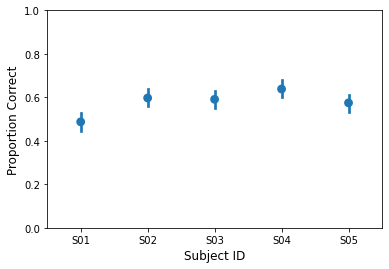

In [4]:
df=behavData#.query("spacing==2")
sns.pointplot(data=df,x='subj_id',y='corr',join=False)
plt.xlabel("Subject ID",size=12)
plt.ylabel("Proportion Correct",size=12)
plt.ylim(0,1)
plt.savefig("..\Plots\Performance_vs_subj.svg",dpi=1200)

In [4]:
codeList=behavData['code'].unique()
markerSacc=[]
for acode in codeList:
    stimulusOnset=markerData.query("code==@acode")['stimulusOnsetTime'].values
    if len(stimulusOnset)==1:
        stimTime=stimulusOnset
        tempSacc=microSaccFiltered.query("code==@acode")
        tempSacc['relOnsetTime']=tempSacc['onsetTime']-stimTime
        tempSacc['reOffsetTime']=tempSacc['offsetTime']-stimTime
        tempSacc['relStimTime']=stimTime-tempSacc['onsetTime']
        markerSacc.append(tempSacc)
    elif len(stimulusOnset)==2: # In this case the second one is invalid
        if stimulusOnset[1]>1.50:
            # We would ignore the second one and use the first
            stimTime=stimulusOnset[0] 
            tempSacc=microSaccFiltered.query("code==@acode")
            tempSacc['relOnsetTime']=tempSacc['onsetTime']-stimTime
            tempSacc['reOffsetTime']=tempSacc['offsetTime']-stimTime
            tempSacc['relStimTime']=stimTime-tempSacc['onsetTime']
            markerSacc.append(tempSacc)
markerSacc=pd.concat(markerSacc)
markerSaccMerge=pd.merge(markerSacc,behavData,left_on='code',right_on='code')

# The saccade directions range from -180 to +180 and uses the atan2d function in matlab. So to retrieve values that range between 0 and 360 we add 360 for values that
# are below 0
markerSaccMerge['DirectionPolar']=0
for i in range(len(markerSaccMerge)):
    if markerSaccMerge['Direction'].iloc[i]<0:
        markerSaccMerge['DirectionPolar'].iloc[i]=markerSaccMerge['Direction'].iloc[i]+360
    else:
        markerSaccMerge['DirectionPolar'].iloc[i]=markerSaccMerge['Direction'].iloc[i]
# here we segregate the microsaccade data based on whether they were leftward or rightward.
# Criterion is based on Baumeler et al. 2020
# Krish June 21': Modified this to include only saccades 45° away from horizontal meridian
rightupSacc=markerSaccMerge.query("DirectionPolar<45 ")
rightdownSacc=markerSaccMerge.query("(DirectionPolar>315)")
rightwardSacc=rightupSacc.append(rightdownSacc)
# Here we flip what we call left & right since the eye traces from the algorithm are flipped
rightwardSacc['leftVright']='right'
leftwardSacc=markerSaccMerge.query("(DirectionPolar>135) & (DirectionPolar<225)")
leftwardSacc['leftVright']='left'
leftVrightData=leftwardSacc.append(rightwardSacc)     
leftVrightData['congruent']= np.where((leftVrightData['stim_loc'] == leftVrightData['leftVright']),1 ,0)



C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [5]:
# We filter saccade events from every trial
# 1. Only use saccade events with Duration>15 ms and Duration<80ms 
# 2. We use events that have inter saccadic interval that is greater than 200 ms
# 3. We also filter data to use samples that fall on the main sequence/remove outliers(artifacts from saccade detectio method)
leftVrightData=leftVrightData.query("0.015<Duration<0.080")

# only use trials that have inter saccadic latency that is greater than 200 ms
df=leftVrightData.groupby(['code'])['onsetTime'].diff().reset_index()
df_filtered=df.query("0<onsetTime<0.200")
# We remove both events that are close together in time
index_array=df_filtered['index'].values
prev_index_array=index_array-1
combined_index_array=np.append(index_array,prev_index_array)
leftVrightData_filtered=leftVrightData.drop(combined_index_array,axis=0)

# #Only use samples that fall along the main sequence plot and show linear relationship
# x=(leftVrightData_filtered.VectorAmp.values)
# y=(leftVrightData_filtered.peakVel.values)
# # First get edges from histogram
# num_bins=150
# counts, yedges, xedges = np.histogram2d(y, x, bins=150)
# # counts, yedges, xedges = np.histogram2d(y, x, bins=num_bins,range=[[0,np.max(y)], [0,np.max(x)]])
# #Hough transform
# from skimage.transform import hough_line, hough_line_peaks
# h, theta, d = hough_line(counts)
# #Plot output
# plt.figure()
# plt.scatter(x, y,s=.01)
# #line x & y values
# x_vals=[]
# y_vals=[]
# slope_vals=[]
# for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
#     (y0,x0) = dist * np.array([np.cos(angle), np.sin(angle)])

#     orig_slope=np.tan(angle + np.pi/2)
#     new_x0=x0/num_bins*(xedges[-2])
#     new_y0=y0/num_bins*(yedges[-2])
#     new_slope=orig_slope*(np.max(yedges)/np.max(xedges))
#     plt.axline((new_x0, new_y0), slope=new_slope)
#     x_vals.append(new_x0)
#     y_vals.append(new_y0)
#     slope_vals.append(new_slope)
# # We get the mid-point
# x_mid=np.sum(x_vals)/2
# y_mid=np.sum(y_vals)/2
# slope_mid=np.sum(slope_vals)/2
# # we draw line in between
# plt.axline((x_mid,y_mid),slope=slope_mid,color='k',ls='--')

# plt.xlabel('Saccade Amplitude (deg)',size=12)
# plt.ylabel('Peak Velocity (°/s)',size=12)
# plt.title('Before Filtering')

# plt.figure()
# below_line=y>(slope_mid*x)
# x_filtered=x[below_line]
# y_filtered=y[below_line]
# plt.scatter(x_filtered,y_filtered,s=.01)
# plt.xlabel('Saccade Amplitude (deg)',size=12)
# plt.ylabel('Peak Velocity (°/s)',size=12)
# plt.title("After Filtering")

# #Finally we tweak the saccade dataframe to use the filtered values
# leftVrightData_filtered=leftVrightData_filtered.loc[leftVrightData_filtered['VectorAmp'].isin(x_filtered)]

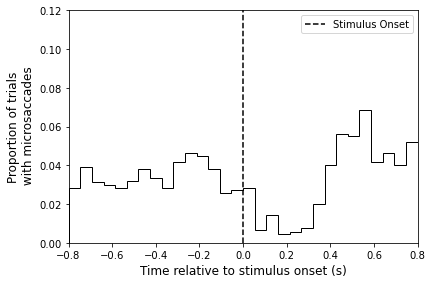

In [10]:
df1=leftVrightData_filtered.query("-0.8<relOnsetTime<0.8")
weights1 = np.ones_like(df1['relOnsetTime'])/float(len(df1['relOnsetTime']))
n, b, patches=plt.hist(df1['relOnsetTime'],weights=weights1,bins=30,histtype='step',ls='-',color='k')
plt.axvline(x=0,ymin=0,ymax=1,ls='--',color=[0,0,0],label='Stimulus Onset')
# plt.axvspan(0, 0.100, alpha=0.5, color='grey',label='Stimulus Window')
plt.xlabel('Time relative to stimulus onset (s)',size=12)
plt.ylabel('Proportion of trials\n with microsaccades',size=12)
plt.tight_layout()
plt.xlim(-0.8,0.8)
plt.ylim(0,0.12)
plt.legend()
# plt.savefig("..\Plots\HistogramofMicrosaccadesWRTstimulusonset.svg",dpi=1200)

In [6]:
# Identify trials without microsaccade
trialWsaccList=df1['code'].unique()
trialWOsaccList=behavData[~behavData.code.isin(trialWsaccList)]['code']
noSaccDF=behavData[~behavData.code.isin(trialWsaccList)]
# Microsaccade metrics binned with respect to stimulus onset

# we would mostly alter this to adjust the step size and smoothing window limit
stepSize=0.002 #seconds
binSize=0.200

startPt=-0.800
endPt=0.800
bins=np.arange(startPt,endPt,stepSize)
binWidth=binSize/2
spacings=leftVrightData_filtered['spacing'].unique()
subs=['S01','S03','S04','S05']
nums=leftVrightData_filtered['target'].unique()
cong_conds=[0,1]
responses=[1,0]
numelements=len(subs)*len(bins)
counter=1
# we create the necessary lists
# first we create lists for the experiment conditions
# First for the performance df
# No microsaccade condition list
BinDataPerf_sacc=[]
perf_list=[]
binList=[]
for asub in subs:
    for abin in bins:
        start=abin-binWidth
        end=abin+binWidth
        # Trials with microsaccades present
        print('%d/%d'%(counter,numelements),end='\r')
        perfDF=leftVrightData_filtered.query("@start<relOnsetTime<@end & subj_id_x==@asub").drop_duplicates(subset=['code'])
        perfDF['binPt']=abin
        BinDataPerf_sacc.append(perfDF)
        counter+=1
                
BinnedPerfData_sacc=pd.concat(BinDataPerf_sacc)

NameError: name 'df1' is not defined

In [15]:
# Common permutation test for all conditions
# We run permutation test for each time point/bin step 
bins=BinnedPerfData_sacc.binPt.unique()
binPtList=[]
p_vals_perf=[]
p_vals_cong=[]
idx=0
# loop through each bin
for abin in bins:
    print('%d/%d'%(idx,len(bins)-1),end='\r')
    idx+=1
    # Performance permutation test [By Congruency]
    group1_perf=np.array(BinnedPerfData_sacc.query("binPt==@abin and congruent==1 & corr<2")['corr'])
    group2_perf=np.array(BinnedPerfData_sacc.query("binPt==@abin and congruent==0 & corr<2")['corr'])
#     df1=bootstrap_corr_to_propCor(group1_perf,num_boot=100)
#     df2=bootstrap_corr_to_propCor(group2_perf,num_boot=100)
    res_perf=perm_test(group1_perf,group2_perf,10000,'mean',z_score=False)
    # append P val
    p_vals_perf.append(res_perf['p_val'])
    binPtList.append(abin)
p_val_df=pd.DataFrame(np.column_stack((binPtList,p_vals_perf)),columns=['binPt','p_val_perf'])

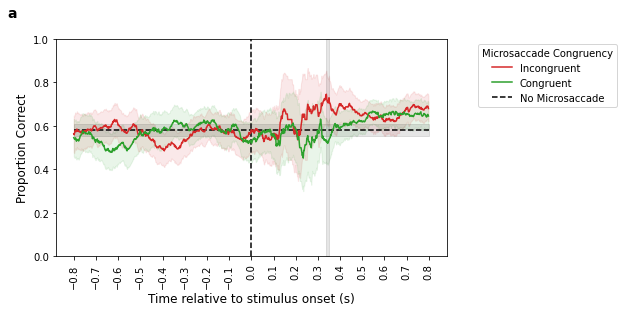

In [9]:
plt.figure(figsize=(7,4))
#### Incongruent Condition
df1_mean=BinnedPerfData_sacc.query("congruent==0").groupby(['binPt'])['corr'].mean().reset_index()
# Compute CI
df1_std=BinnedPerfData_sacc.query("congruent==0").groupby(['binPt'])['corr'].std().reset_index()
df1_count=BinnedPerfData_sacc.query("congruent==0").groupby(['binPt'])['corr'].count().reset_index()
ci1=1.96 * (df1_std['corr'])/np.sqrt(df1_count['corr']) 
x1=df1_std['binPt']
plt.plot(df1_mean['binPt'],df1_mean['corr'],label='Incongruent',color='C3')
plt.fill_between(x1,(df1_mean['corr']+ci1),(df1_mean['corr']-ci1),color='C3',alpha=0.1)

#Congruent Condition
df2_mean=BinnedPerfData_sacc.query("congruent==1").groupby(['binPt'])['corr'].mean().reset_index()
# Compute CI
df2_std=BinnedPerfData_sacc.query("congruent==1").groupby(['binPt'])['corr'].std().reset_index()
df2_count=BinnedPerfData_sacc.query("congruent==1").groupby(['binPt'])['corr'].count().reset_index()
x2=df2_std['binPt']
ci2=1.96 * (df2_std['corr'])/np.sqrt(df2_count['corr']) 
plt.plot(df2_mean['binPt'],df2_mean['corr'],label='Congruent',color='C2')
plt.fill_between(x2,(df2_mean['corr']+ci2),(df2_mean['corr']-ci2),color='C2',alpha=0.1)

#No saccade condition
df3_mean=noSaccDF['corr'].mean()
# Compute CI
df3_std=noSaccDF['corr'].std()
df3_count=noSaccDF['corr'].count()
ci3=1.96 * (df3_std)/np.sqrt(df3_count) 
xvalues=np.linspace(-.8,0.8,5)
plt.hlines(xmin=-0.8,xmax=0.8,y=df3_mean,label='No Microsaccade',color='k',linestyle='--')
plt.fill_between(xvalues,(df3_mean+ci3),(df3_mean-ci3),color='k',alpha=0.1)

plt.vlines(0,ymin=0,ymax=1,linestyle='--',color=[0,0,0])
plt.legend(title='Microsaccade Congruency',bbox_to_anchor=(1.45,1))
plt.ylim(0,1)
plt.xticks(np.arange(-0.8,0.9,0.1),rotation=90)

plt.ylabel('Proportion Correct',size=12)
plt.xlabel('Time relative to stimulus onset (s)',size=12)

# # we plot significance over this
p_vals_perf=p_val_df['p_val_perf'].values
bins=p_val_df['binPt'].values
alpha_lvl=0.005
start_bins=[]
end_bins=[]
got_one=0
for idx in range(len(p_vals_perf)):
    a_pval=p_vals_perf[idx]
    abin=bins[idx]
    if a_pval<alpha_lvl and got_one==0:
        prev_pt=abin
        start_bins.append(abin)
        got_one=1
    elif a_pval>alpha_lvl and got_one==1 and (abin-prev_pt)>0.010:
        end_bins.append(abin)
        got_one=0
    elif a_pval<alpha_lvl and got_one==1 and (abin-prev_pt)<0.030:
        pass
# We plot between the start and end of the region where it is significant
for i in range(len(end_bins)):
    start_pt=start_bins[i]
    end_pt=end_bins[i]
    plt.fill_betweenx(y=[0,1],x1=start_pt,x2=end_pt,color=[0,0,0],alpha=0.1) 
plt.text(-1.1,1.1,r'$\bf{a}$',size=14)
plt.savefig("..\Plots\MicrosaccadeVbehavioralPerformance_hue_congruency.pdf",dpi=1200,bbox_inches='tight')

In [21]:
# Common permutation test for all conditions
# We run permutation test for each time point/bin step 
bins=BinnedPerfData_sacc.binPt.unique()
binPtList=[]
p_vals_perf=[]
p_vals_cong=[]
idx=0
# loop through each bin
for abin in bins:
    print('%d/%d'%(idx,len(bins)-1),end='\r')
    idx+=1
    # Performance permutation test [By Congruency]
    group1_perf=np.array(BinnedPerfData_sacc.query("binPt==@abin and congruent==1 & corr<2")['corr'])
    group2_perf=np.array(noSaccDF.query(" corr<2")['corr'])
#     df1=bootstrap_corr_to_propCor(group1_perf,num_boot=100)
#     df2=bootstrap_corr_to_propCor(group2_perf,num_boot=100)
    res_perf=perm_test(group1_perf,group2_perf,1000,'mean',z_score=False)
    # append P val
    p_vals_perf.append(res_perf['p_val'])
    binPtList.append(abin)
p_val_df_cong=pd.DataFrame(np.column_stack((binPtList,p_vals_perf)),columns=['binPt','p_val_perf'])
p_val_df_cong['congruency']='congruent'

bins=BinnedPerfData_sacc.binPt.unique()
binPtList=[]
p_vals_perf=[]
p_vals_cong=[]
idx=0
# loop through each bin
for abin in bins:
    print('%d/%d'%(idx,len(bins)-1),end='\r')
    idx+=1
    # Performance permutation test [By Congruency]
    group1_perf=np.array(BinnedPerfData_sacc.query("binPt==@abin and congruent==0 & corr<2")['corr'])
    group2_perf=np.array(noSaccDF.query(" corr<2")['corr'])
#     df1=bootstrap_corr_to_propCor(group1_perf,num_boot=100)
#     df2=bootstrap_corr_to_propCor(group2_perf,num_boot=100)
    res_perf=perm_test(group1_perf,group2_perf,1000,'mean',z_score=False)
    # append P val
    p_vals_perf.append(res_perf['p_val'])
    binPtList.append(abin)
p_val_df_incong=pd.DataFrame(np.column_stack((binPtList,p_vals_perf)),columns=['binPt','p_val_perf'])
p_val_df_incong['congruency']='incongruent'

p_val_df_congruency=p_val_df_cong.append(p_val_df_incong)

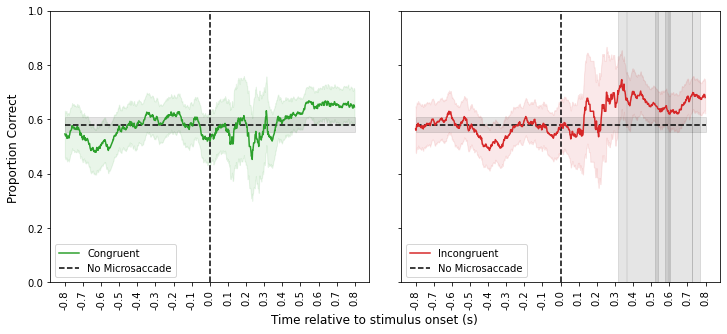

In [47]:
fig,ax=plt.subplots(1,2,sharey=True,figsize=(12,5))
counter=0
for col in ax:
    if counter==0:
        #Congruent Condition
        df2_mean=BinnedPerfData_sacc.query("congruent==1").groupby(['binPt'])['corr'].mean().reset_index()
        # Compute CI
        df2_std=BinnedPerfData_sacc.query("congruent==1").groupby(['binPt'])['corr'].std().reset_index()
        df2_count=BinnedPerfData_sacc.query("congruent==1").groupby(['binPt'])['corr'].count().reset_index()
        x2=df2_std['binPt']
        ci2=1.96 * (df2_std['corr'])/np.sqrt(df2_count['corr']) 
        col.plot(df2_mean['binPt'],df2_mean['corr'],label='Congruent',color='C2')
        col.fill_between(x2,(df2_mean['corr']+ci2),(df2_mean['corr']-ci2),color='C2',alpha=0.1)

        #No saccade condition
        df3_mean=noSaccDF['corr'].mean()
        # Compute CI
        df3_std=noSaccDF['corr'].std()
        df3_count=noSaccDF['corr'].count()
        ci3=1.96 * (df3_std)/np.sqrt(df3_count) 
        xvalues=np.linspace(-.8,0.8,5)
        col.hlines(xmin=-0.8,xmax=0.8,y=df3_mean,label='No Microsaccade',color='k',linestyle='--')
        col.fill_between(xvalues,(df3_mean+ci3),(df3_mean-ci3),color='k',alpha=0.1)
        
        col.vlines(0,ymin=0,ymax=1,linestyle='--',color=[0,0,0])
        col.set_ylim(0,1)
        
        col.legend(loc='lower left')
        p_val_df=p_val_df_congruency.query("congruency=='congruent'")
    else:
        #### Incongruent Condition
        df1_mean=BinnedPerfData_sacc.query("congruent==0").groupby(['binPt'])['corr'].mean().reset_index()
        # Compute CI
        df1_std=BinnedPerfData_sacc.query("congruent==0").groupby(['binPt'])['corr'].std().reset_index()
        df1_count=BinnedPerfData_sacc.query("congruent==0").groupby(['binPt'])['corr'].count().reset_index()
        ci1=1.96 * (df1_std['corr'])/np.sqrt(df1_count['corr']) 
        x1=df1_std['binPt']
        col.plot(df1_mean['binPt'],df1_mean['corr'],label='Incongruent',color='C3')
        col.fill_between(x1,(df1_mean['corr']+ci1),(df1_mean['corr']-ci1),color='C3',alpha=0.1)
        
        #No saccade condition
        df3_mean=noSaccDF['corr'].mean()
        # Compute CI
        df3_std=noSaccDF['corr'].std()
        df3_count=noSaccDF['corr'].count()
        ci3=1.96 * (df3_std)/np.sqrt(df3_count) 
        xvalues=np.linspace(-.8,0.8,5)
        col.hlines(xmin=-0.8,xmax=0.8,y=df3_mean,label='No Microsaccade',color='k',linestyle='--')
        col.fill_between(xvalues,(df3_mean+ci3),(df3_mean-ci3),color='k',alpha=0.1)
        
        col.vlines(0,ymin=0,ymax=1,linestyle='--',color=[0,0,0])
        col.set_ylim(0,1)
        
        col.legend(loc='lower left')
        p_val_df=p_val_df_congruency.query("congruency=='incongruent'")
            
    # # we plot significance over this
    if len(p_val_df)>0:
        p_vals_perf=p_val_df['p_val_perf'].values
        bins=p_val_df['binPt'].values
        alpha_lvl=0.05
        start_bins=[]
        end_bins=[]
        got_one=0
        for idx in range(len(p_vals_perf)):
            a_pval=p_vals_perf[idx]
            abin=bins[idx]
            if a_pval<alpha_lvl and got_one==0:
                prev_pt=abin
                start_bins.append(abin)
                got_one=1
            elif a_pval>alpha_lvl and got_one==1 and (abin-prev_pt)>0.030:
                end_bins.append(abin)
                got_one=0
        # We plot between the start and end of the region where it is significant
        for i in range(len(end_bins)):
            start_pt=start_bins[i]
            end_pt=end_bins[i]
            if start_pt>0:
                plt.fill_betweenx(y=[0,1],x1=start_pt,x2=end_pt,color=[0,0,0],alpha=0.1) 
    counter+=1
    col.set_xticks(np.arange(-0.8,0.9,0.1))
    col.set_xticklabels(['-0.8','-0.7','-0.6','-0.5','-0.4','-0.3','-0.2','-0.1','0.0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8'],rotation=90)
fig.text(0.5,0.01,"Time relative to stimulus onset (s)",size=12,ha='center')
fig.text(0.075,0.5,"Proportion Correct",size=12,rotation=90,va='center')
fig.subplots_adjust(wspace=0.1)

plt.savefig("..\Plots\MicrosaccadeVbehavioralPerformance_comparedWNoSaccDF.svg",dpi=1200)

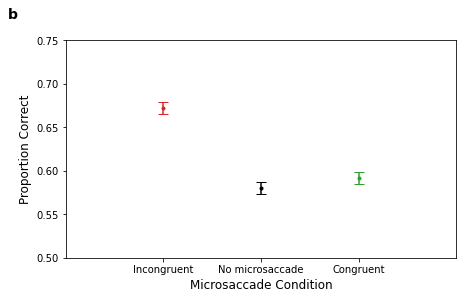

In [6]:
plt.figure(figsize=(7,4))
# Only show performance measure within the ROI from the main experiment 
df=BinnedPerfData_sacc.query("0.150<binPt<0.496")

#First plot the data from the congruent condition
df2_mean=df.query("congruent==1")['corr'].mean()
# Compute CI
df2_std=df.query("congruent==1")['corr'].std()
df2_count=df.query("congruent==1")['corr'].count()
ci2=1.96 * (df2_std)/np.sqrt(df2_count) 
x_val=1
plt.plot(x_val,df2_mean,color='C2',marker='.')
#col.fill_between(x2,(df2_mean['corr']+ci2),(df2_mean['corr']-ci2),color='C2',alpha=0.1)
plt.errorbar(x_val,df2_mean,yerr=ci2,color='C2',ls = 'none',capsize = 5)

# Then plot the data from the incongruent condition
df3_mean=df.query("congruent==0")['corr'].mean()
# Compute CI
df3_std=df.query("congruent==0")['corr'].std()
df3_count=df.query("congruent==0")['corr'].count()
ci3=1.96 * (df2_std)/np.sqrt(df2_count) 
x_val=0
plt.plot(x_val,df3_mean,color='C3',marker='.')
#col.fill_between(x2,(df2_mean['corr']+ci2),(df2_mean['corr']-ci2),color='C2',alpha=0.1)
plt.errorbar(x_val,df3_mean,yerr=ci2,color='C3',ls = 'none',capsize = 5)

# Then plot the data from the no saccade condition
df4_mean=noSaccDF['corr'].mean()
# Compute CI
df4_std=noSaccDF['corr'].std()
df4_count=noSaccDF['corr'].count()
ci4=1.96 * (df2_std)/np.sqrt(df2_count) 
x_val=0.5
plt.plot(x_val,df4_mean,color='k',marker='.')
#col.fill_between(x2,(df2_mean['corr']+ci2),(df2_mean['corr']-ci2),color='C2',alpha=0.1)
plt.errorbar(x_val,df4_mean,yerr=ci4,color='k',ls = 'none',capsize = 5)

plt.xticks([0,0.5,1],labels=['Incongruent',"No microsaccade",'Congruent'])
plt.xlim(-0.5,1.5)
plt.ylim(0.5,0.75)
plt.ylabel("Proportion Correct",size=12)
plt.xlabel("Microsaccade Condition",size=12)
plt.text(-0.8,0.775,r'$\bf{b}$',size=14)
plt.savefig("..\Plots\PerformanceVmicrosaccadeCondition_150to494ms.pdf",dpi=1200)

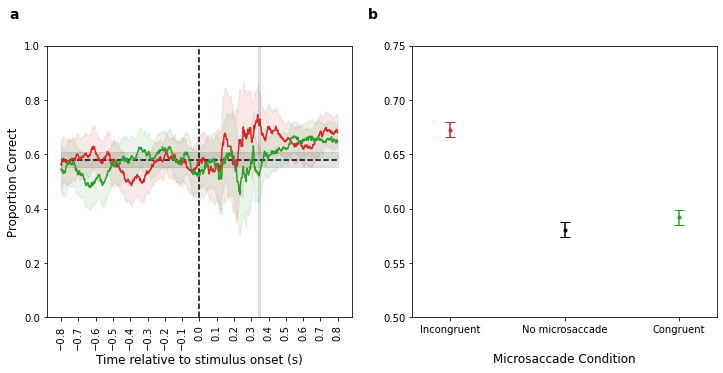

In [44]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(12,5))
counter=0
for col in ax:
    if counter==0:
        #### Incongruent Condition
        df1_mean=BinnedPerfData_sacc.query("congruent==0").groupby(['binPt'])['corr'].mean().reset_index()
        # Compute CI
        df1_std=BinnedPerfData_sacc.query("congruent==0").groupby(['binPt'])['corr'].std().reset_index()
        df1_count=BinnedPerfData_sacc.query("congruent==0").groupby(['binPt'])['corr'].count().reset_index()
        ci1=1.96 * (df1_std['corr'])/np.sqrt(df1_count['corr']) 
        x1=df1_std['binPt']
        col.plot(df1_mean['binPt'],df1_mean['corr'],label='Incongruent',color='C3')
        col.fill_between(x1,(df1_mean['corr']+ci1),(df1_mean['corr']-ci1),color='C3',alpha=0.1)

        #Congruent Condition
        df2_mean=BinnedPerfData_sacc.query("congruent==1").groupby(['binPt'])['corr'].mean().reset_index()
        # Compute CI
        df2_std=BinnedPerfData_sacc.query("congruent==1").groupby(['binPt'])['corr'].std().reset_index()
        df2_count=BinnedPerfData_sacc.query("congruent==1").groupby(['binPt'])['corr'].count().reset_index()
        x2=df2_std['binPt']
        ci2=1.96 * (df2_std['corr'])/np.sqrt(df2_count['corr']) 
        col.plot(df2_mean['binPt'],df2_mean['corr'],label='Congruent',color='C2')
        col.fill_between(x2,(df2_mean['corr']+ci2),(df2_mean['corr']-ci2),color='C2',alpha=0.1)

        #No saccade condition
        df3_mean=noSaccDF['corr'].mean()
        # Compute CI
        df3_std=noSaccDF['corr'].std()
        df3_count=noSaccDF['corr'].count()
        ci3=1.96 * (df3_std)/np.sqrt(df3_count) 
        xvalues=np.linspace(-.8,0.8,5)
        col.hlines(xmin=-0.8,xmax=0.8,y=df3_mean,label='No Microsaccade',color='k',linestyle='--')
        col.fill_between(xvalues,(df3_mean+ci3),(df3_mean-ci3),color='k',alpha=0.1)

        col.vlines(0,ymin=0,ymax=1,linestyle='--',color=[0,0,0])
        #col.set_legend(title='Microsaccade Congruency',bbox_to_anchor=(1.45,1))
        col.set_ylim(0,1)
        col.set_xticks(np.arange(-0.8,0.9,0.1))
        for tick in col.get_xticklabels():
            tick.set_rotation(90)

        col.set_ylabel('Proportion Correct',size=12)
        col.set_xlabel('Time relative to stimulus onset (s)',size=12)

        # # we plot significance over this
        p_vals_perf=p_val_df['p_val_perf'].values
        bins=p_val_df['binPt'].values
        alpha_lvl=0.005
        start_bins=[]
        end_bins=[]
        got_one=0
        for idx in range(len(p_vals_perf)):
            a_pval=p_vals_perf[idx]
            abin=bins[idx]
            if a_pval<alpha_lvl and got_one==0:
                prev_pt=abin
                start_bins.append(abin)
                got_one=1
            elif a_pval>alpha_lvl and got_one==1 and (abin-prev_pt)>0.010:
                end_bins.append(abin)
                got_one=0
            elif a_pval<alpha_lvl and got_one==1 and (abin-prev_pt)<0.030:
                pass
        # We plot between the start and end of the region where it is significant
        for i in range(len(end_bins)):
            start_pt=start_bins[i]
            end_pt=end_bins[i]
            col.fill_betweenx(y=[0,1],x1=start_pt,x2=end_pt,color=[0,0,0],alpha=0.1) 
        col.text(-1.1,1.1,r'$\bf{a}$',size=14)
    else:
        # Only show performance measure within the ROI from the main experiment 
        df=BinnedPerfData_sacc.query("0.150<binPt<0.496")

        #First plot the data from the congruent condition
        df2_mean=df.query("congruent==1")['corr'].mean()
        # Compute CI
        df2_std=df.query("congruent==1")['corr'].std()
        df2_count=df.query("congruent==1")['corr'].count()
        ci2=1.96 * (df2_std)/np.sqrt(df2_count) 
        x_val=1.25
        col.plot(x_val,df2_mean,color='C2',marker='.')
        #col.fill_between(x2,(df2_mean['corr']+ci2),(df2_mean['corr']-ci2),color='C2',alpha=0.1)
        col.errorbar(x_val,df2_mean,yerr=ci2,color='C2',ls = 'none',capsize = 5)

        # Then plot the data from the incongruent condition
        df3_mean=df.query("congruent==0")['corr'].mean()
        # Compute CI
        df3_std=df.query("congruent==0")['corr'].std()
        df3_count=df.query("congruent==0")['corr'].count()
        ci3=1.96 * (df2_std)/np.sqrt(df2_count) 
        x_val=-0.25
        col.plot(x_val,df3_mean,color='C3',marker='.')
        #col.fill_between(x2,(df2_mean['corr']+ci2),(df2_mean['corr']-ci2),color='C2',alpha=0.1)
        col.errorbar(x_val,df3_mean,yerr=ci2,color='C3',ls = 'none',capsize = 5)

        # Then plot the data from the no saccade condition
        df4_mean=noSaccDF['corr'].mean()
        # Compute CI
        df4_std=noSaccDF['corr'].std()
        df4_count=noSaccDF['corr'].count()
        ci4=1.96 * (df2_std)/np.sqrt(df2_count) 
        x_val=0.5
        col.plot(x_val,df4_mean,color='k',marker='.')
        #col.fill_between(x2,(df2_mean['corr']+ci2),(df2_mean['corr']-ci2),color='C2',alpha=0.1)
        col.errorbar(x_val,df4_mean,yerr=ci4,color='k',ls = 'none',capsize = 5)

        col.set_xticks([-0.25,0.5,1.25])#,labels=['Incongruent',"No microsaccade",'Congruent'])
        col.set_xticklabels(labels=['Incongruent',"No microsaccade",'Congruent'])
        col.set_xlim(-0.5,1.5)
        col.set_ylim(0.5,0.75)
        col.set_xlabel("Microsaccade Condition",size=12,labelpad=18)
        col.text(-0.8,0.775,r'$\bf{b}$',size=14)
    counter+=1
plt.savefig("..\Plots\PerformanceVmicrosaccadeCondition_combined.pdf",dpi=1200,bbox_inches='tight')

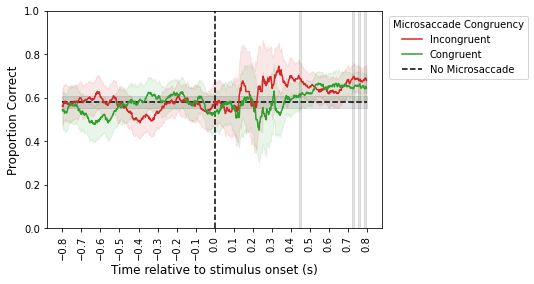

In [7]:
#### Incongruent Condition
df1_mean=BinnedPerfData_sacc.query("congruent==0").groupby(['binPt'])['corr'].mean().reset_index()
# Compute CI
df1_std=BinnedPerfData_sacc.query("congruent==0").groupby(['binPt'])['corr'].std().reset_index()
df1_count=BinnedPerfData_sacc.query("congruent==0").groupby(['binPt'])['corr'].count().reset_index()
ci1=1.96 * (df1_std['corr'])/np.sqrt(df1_count['corr']) 
x1=df1_std['binPt']
plt.plot(df1_mean['binPt'],df1_mean['corr'],label='Incongruent',color='C3')
plt.fill_between(x1,(df1_mean['corr']+ci1),(df1_mean['corr']-ci1),color='C3',alpha=0.1)

#Congruent Condition
df2_mean=BinnedPerfData_sacc.query("congruent==1").groupby(['binPt'])['corr'].mean().reset_index()
# Compute CI
df2_std=BinnedPerfData_sacc.query("congruent==1").groupby(['binPt'])['corr'].std().reset_index()
df2_count=BinnedPerfData_sacc.query("congruent==1").groupby(['binPt'])['corr'].count().reset_index()
x2=df2_std['binPt']
ci2=1.96 * (df2_std['corr'])/np.sqrt(df2_count['corr']) 
plt.plot(df2_mean['binPt'],df2_mean['corr'],label='Congruent',color='C2')
plt.fill_between(x2,(df2_mean['corr']+ci2),(df2_mean['corr']-ci2),color='C2',alpha=0.1)

#No saccade condition
df3_mean=noSaccDF['corr'].mean()
# Compute CI
df3_std=noSaccDF['corr'].std()
df3_count=noSaccDF['corr'].count()
ci3=1.96 * (df3_std)/np.sqrt(df3_count) 
xvalues=np.linspace(-.8,0.8,5)
plt.hlines(xmin=-0.8,xmax=0.8,y=df3_mean,label='No Microsaccade',color='k',linestyle='--')
plt.fill_between(xvalues,(df3_mean+ci3),(df3_mean-ci3),color='k',alpha=0.1)

plt.vlines(0,ymin=0,ymax=1,linestyle='--',color=[0,0,0])
plt.legend(title='Microsaccade Congruency',bbox_to_anchor=(1.45,1))
plt.ylim(0,1)
plt.xticks(np.arange(-0.8,0.9,0.1),rotation=90)

plt.ylabel('Proportion Correct',size=12)
plt.xlabel('Time relative to stimulus onset (s)',size=12)

# # we plot significance over this
p_vals_perf=p_val_df['p_val_perf'].values
bins=p_val_df['binPt'].values
alpha_lvl=0.001
start_bins=[]
end_bins=[]
got_one=0
for idx in range(len(p_vals_perf)):
    a_pval=p_vals_perf[idx]
    abin=bins[idx]
    if a_pval<alpha_lvl and got_one==0:
        prev_pt=abin
        start_bins.append(abin)
        got_one=1
    elif a_pval>alpha_lvl and got_one==1 and (abin-prev_pt)>0.010:
        end_bins.append(abin)
        got_one=0
    elif a_pval<alpha_lvl and got_one==1 and (abin-prev_pt)<0.030:
        pass
# We plot between the start and end of the region where it is significant
for i in range(len(end_bins)):
    start_pt=start_bins[i]
    end_pt=end_bins[i]
    plt.fill_betweenx(y=[0,1],x1=start_pt,x2=end_pt,color=[0,0,0],alpha=0.1) 

In [70]:
# Microsaccade metrics binned with respect to stimulus onset
# All microsaccade together
import warnings
warnings.filterwarnings("ignore")
# we would mostly alter this to adjust the step size and smoothing window limit
stepSize=0.002#seconds
binSize=0.200

startPt=-0.800
endPt=0.800
bins=np.arange(startPt,endPt,stepSize)
binWidth=binSize/2
spacings=leftVrightData_filtered['spacing'].unique()
stim_locs=leftVrightData_filtered['stim_loc'].unique()
# nums=leftVrightData_filtered.target.uniqueftVright'].unique()
subs=['S01','S03','S04','S05']
responses=[1,0]
congruencies=leftVrightData_filtered.congruent.unique()
nums=leftVrightData_filtered['target'].unique()
numelements=len(subs)*len(bins)
counter=1
# we create the necessary lists
# first we create lists for the experiment conditions
BinnedData=[]

for asub in subs:
    for abin in bins:
        start=abin-binWidth
        end=abin+binWidth
        print('%d/%d'%(counter,numelements),end='\r')
        tempDF=leftVrightData_filtered.query("@start<relOnsetTime<@end & subj_id_x==@asub").drop_duplicates(subset=['code'])
        tempDF['binPt']=abin
        BinnedData.append(tempDF)
        counter+=1

BinnedData=pd.concat(BinnedData)
# # #we then save the dataframes
# BinData.to_pickle('BinnedData_%dmsStep_%dmsSize_finerTuning_Horz.pkl'%((stepSize*1000),(binSize*1000)))


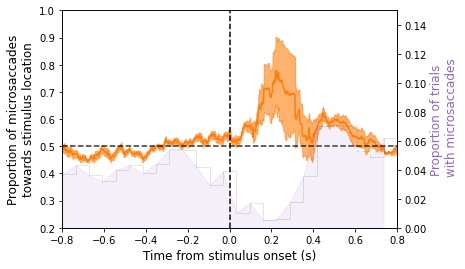

In [72]:
# Pre-process data
def col_to_code(x):
    return "%s_%s"%(x.subj_id_x,x.binPt)
# Get proportion congruent
df1=BinnedData.query("congruent==1").groupby(['binPt','subj_id_x'])['congruent'].sum().reset_index()
df1['code']=(df1.apply(col_to_code,1)).astype(str)
df2=BinnedData.groupby(['binPt','subj_id_x'])['congruent'].count().reset_index()
df2['code']=(df2.apply(col_to_code,1)).astype(str)
df=pd.merge(df1,df2,left_on='code',right_on='code')
df['propCong']=df['congruent_x']/df['congruent_y']

# Now we plot
df_mean=df.groupby(['binPt_x'])['propCong'].mean().reset_index()
# compute CI
df_std=df.groupby(['binPt_x'])['propCong'].std().reset_index()
df_count=df.groupby(["binPt_x"])['congruent_y'].mean().reset_index()
x=df_std['binPt_x']
# Column congruent y from before indicates the total count of microsaccades grouped by bin point
ci=1.96 * (df_std['propCong'])/np.sqrt(df_count['congruent_y']) 
fig,ax1=plt.subplots()
ax_twin=ax1.twinx()
ax1.fill_between(x,(df_mean['propCong']+ci),(df_mean['propCong']-ci),color='C1',alpha=0.6)
ax1.plot(df_mean['binPt_x'],df_mean['propCong'],color='C1')
ax1.set_ylim(0.2,1)
ax1.set_xlim(-0.8,0.8)
ax1.axvline(x=0,ymin=0,ymax=1,linestyle='--',color=[0,0,0])
ax1.axhline(xmin=0,xmax=1,y=0.5,linestyle='--',color=[0,0,0],alpha=0.8)
ax1.set_ylabel('Proportion of microsaccades\ntowards stimulus location',size=12)
ax1.set_xlabel('Time from stimulus onset (s)',size=12)

df1=leftVrightData.query("-0.8<relOnsetTime<0.8")
weights1 = np.ones_like(df1['relOnsetTime'])/float(len(df1['relOnsetTime']))                                              
hist,patches,obj=ax_twin.hist(df1['relOnsetTime'],weights=weights1,bins=25,histtype='step',ls='-',color='k',alpha=0.1)
ax_twin.fill_between(patches[:-1],hist*0,hist,alpha=0.1,color='C4')
ax_twin.set_ylabel('Proportion of trials\n with microsaccades',size=12,color='C4')
ax_twin.axes.set_ylim(0,0.15)

plt.savefig('..\Plots\DirectionalModulationMicrosaccade.svg',format='svg',dpi=1200,bbox_inches='tight')